# Regression using Pytorch

In [30]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

from source.ffnn_model import WellLogFFNN
from source.well_data_preprocessing import load_log_data

# Reproducibility, gotten from project 2
NP_RANDOM_SEED = 42
torch.manual_seed(NP_RANDOM_SEED)
np.random.seed(NP_RANDOM_SEED)


In [31]:
(X_train, y_train), (X_val, y_val), (X_test, y_test), x_scaler, y_scaler = load_log_data(None)

print("Shapes:")
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("X_val:",   X_val.shape)
print("X_test:",  X_test.shape)



Data shape after cleaning: X=(12428, 11), y=(12428,)
Shapes:
X_train: torch.Size([8699, 11])
y_train: torch.Size([8699, 1])
X_val: torch.Size([1864, 11])
X_test: torch.Size([1865, 11])


In [32]:
# Basic statistics of y_train
print("y_train min:", y_train.min().item())
print("y_train max:", y_train.max().item())
print("y_train mean:", y_train.mean().item())
print("y_train std:", y_train.std().item())


y_train min: -5.131324768066406
y_train max: 3.104504108428955
y_train mean: 8.770427162296812e-10
y_train std: 1.0000574588775635


In [33]:
import lasio
import os
import numpy as np

current_dir = os.path.dirname(os.path.abspath("../code/source/well_data_preprocessing.py"))
las_path = "../../datasets/Well_data/1_9-7_LOGS.LAS"
full_path = os.path.join("/Users/erikberthelsen/Library/Mobile Documents/com~apple~CloudDocs/7_semester_Master/FYS-STK/sisteprosjekt/sisteprosjekt/code/source", las_path)

las = lasio.read(full_path)
df = las.df().reset_index()


In [ ]:
"""

Defining model and training function.

The model is a feedforward neural network defined in source/ffnn_model.py.

The training function uses MSE loss and Adam optimizer.

Code is adapted from project 2 part c.

"""

input_dim = X_train.shape[1]

# Defining model
def make_model(hidden_dims=(64, 64), dropout=0.2, activation=nn.ReLU):
    return WellLogFFNN(
        input_dim=input_dim,
        hidden_dims=hidden_dims,
        dropout=dropout,
        activation=activation,
    )
# Training function
def train_model(
    model,
    X_train, y_train,
    X_val,   y_val,
    lr: float = 1e-3,
    epochs: int = 100,
    verbose: bool = False,
):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    best_val_loss = float("inf")
    best_state_dict = None

    train_losses = []
    val_losses   = []

    for epoch in range(epochs):
        # ---- TRAIN ----
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

        # ---- VALIDATION ----
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val)
            val_loss = criterion(val_outputs, y_val).item()
        val_losses.append(val_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_state_dict = model.state_dict()

        if verbose and (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1:4d} | Train MSE: {loss.item():.4f} | Val MSE: {val_loss:.4f}")

    # last best weights
    if best_state_dict is not None:
        model.load_state_dict(best_state_dict)

    return model, best_val_loss, train_losses, val_losses


In [35]:
# Training with different configurations and evaluating on test set
configs = [
    {"name": "small_no_dropout",  "hidden_dims": (32, 32),        "lr": 1e-3, "dropout": 0.0},
    {"name": "medium_dropout",    "hidden_dims": (64, 64),        "lr": 1e-3, "dropout": 0.2},
    {"name": "deep_dropout",      "hidden_dims": (128, 64, 32),   "lr": 1e-4, "dropout": 0.2},
    {"name": "medium_lr_high",    "hidden_dims": (64, 64),        "lr": 1e-2, "dropout": 0.2},
]

results = []
histories = {}

for cfg in configs:
    print(f"\n=== Training config: {cfg['name']} ===")
    print(f"hidden_dims={cfg['hidden_dims']}, lr={cfg['lr']}, dropout={cfg['dropout']}")

    torch.manual_seed(NP_RANDOM_SEED)
    np.random.seed(NP_RANDOM_SEED)

    model = make_model(
        hidden_dims=cfg["hidden_dims"],
        dropout=cfg["dropout"],
        activation=nn.ReLU,
    )

    model, best_val_mse, train_losses, val_losses = train_model(
        model,
        X_train, y_train,
        X_val,   y_val,
        lr=cfg["lr"],
        epochs=100,
        verbose=False,
    )

    # evaluate on test set
    model.eval()
    with torch.no_grad():
        y_pred_test = model(X_test)
        test_mse = nn.MSELoss()(y_pred_test, y_test).item()

    results.append({
        "name":        cfg["name"],
        "hidden_dims": cfg["hidden_dims"],
        "lr":          cfg["lr"],
        "dropout":     cfg["dropout"],
        "val_mse":     best_val_mse,
        "test_mse":    test_mse,
    })

    histories[cfg["name"]] = {
        "train_losses": train_losses,
        "val_losses":   val_losses,
    }

results_df = pd.DataFrame(results)
display(results_df)



=== Training config: small_no_dropout ===
hidden_dims=(32, 32), lr=0.001, dropout=0.0

=== Training config: medium_dropout ===
hidden_dims=(64, 64), lr=0.001, dropout=0.2

=== Training config: medium_dropout ===
hidden_dims=(64, 64), lr=0.001, dropout=0.2

=== Training config: deep_dropout ===
hidden_dims=(128, 64, 32), lr=0.0001, dropout=0.2

=== Training config: deep_dropout ===
hidden_dims=(128, 64, 32), lr=0.0001, dropout=0.2

=== Training config: medium_lr_high ===
hidden_dims=(64, 64), lr=0.01, dropout=0.2

=== Training config: medium_lr_high ===
hidden_dims=(64, 64), lr=0.01, dropout=0.2


,name,hidden_dims,lr,dropout,val_mse,test_mse
0,small_no_dropout,"(32, 32)",0.0010,0.0,0.278092,0.296842
1,medium_dropout,"(64, 64)",0.0010,0.2,0.245893,0.260679
2,deep_dropout,"(128, 64, 32)",0.0001,0.2,0.764823,0.736259
3,medium_lr_high,"(64, 64)",0.0100,0.2,0.168799,0.189580


In [36]:
import optuna
from optuna.trial import Trial  

# Define objective function for Optuna
def objective(trial: Trial):
    """Objective function for Optuna hyperparameter optimization."""
    
    # Suggest hyperparameters
    hidden_dim1 = trial.suggest_int("hidden_dim1", 16, 256, step=16)
    hidden_dim2 = trial.suggest_int("hidden_dim2", 16, 256, step=16)
    hidden_dim3 = trial.suggest_int("hidden_dim3", 16, 256, step=16)
    n_layers = trial.suggest_int("n_layers", 2, 4)
    dropout = trial.suggest_float("dropout", 0.0, 0.5, step=0.1)
    lr = trial.suggest_float("lr", 1e-5, 1e-2, log=True)
    
    # Build hidden_dims tuple based on n_layers
    hidden_dims_list = [hidden_dim1, hidden_dim2, hidden_dim3][:n_layers]
    hidden_dims = tuple(hidden_dims_list)
    
    # Reset seeds for reproducibility
    torch.manual_seed(NP_RANDOM_SEED)
    np.random.seed(NP_RANDOM_SEED)
    
    # Create and train model
    model = make_model(
        hidden_dims=hidden_dims,
        dropout=dropout,
        activation=nn.ReLU,
    )
    
    model, best_val_mse, _, _ = train_model(
        model,
        X_train, y_train,
        X_val, y_val,
        lr=lr,
        epochs=100,
        verbose=False,
    )
    
    return best_val_mse

# Create and run Optuna study
print("Starting Optuna hyperparameter optimization...")
study = optuna.create_study(
    direction="minimize",
    sampler=optuna.samplers.TPESampler(seed=NP_RANDOM_SEED),
)

study.optimize(objective, n_trials=50, show_progress_bar=True)

# Get best trial
best_trial = study.best_trial

print("\n" + "="*60)
print("OPTUNA OPTIMIZATION RESULTS")
print("="*60)
print(f"Best validation MSE: {best_trial.value:.6f}")
print("\nBest hyperparameters:")
for key, value in best_trial.params.items():
    print(f"  {key}: {value}")
print("="*60)


[I 2025-12-08 10:36:13,449] A new study created in memory with name: no-name-a1cdf460-c901-40c0-a22c-ef2c6c0b5280


Starting Optuna hyperparameter optimization...


Best trial: 0. Best value: 0.728466:   2%|▏         | 1/50 [00:06<05:09,  6.33s/it]

[I 2025-12-08 10:36:19,786] Trial 0 finished with value: 0.7284659147262573 and parameters: {'hidden_dim1': 96, 'hidden_dim2': 256, 'hidden_dim3': 192, 'n_layers': 3, 'dropout': 0.0, 'lr': 2.9375384576328295e-05}. Best is trial 0 with value: 0.7284659147262573.


Best trial: 1. Best value: 0.149768:   4%|▍         | 2/50 [00:09<03:36,  4.51s/it]

[I 2025-12-08 10:36:23,020] Trial 1 finished with value: 0.1497683823108673 and parameters: {'hidden_dim1': 16, 'hidden_dim2': 224, 'hidden_dim3': 160, 'n_layers': 4, 'dropout': 0.0, 'lr': 0.008123245085588688}. Best is trial 1 with value: 0.1497683823108673.


Best trial: 1. Best value: 0.149768:   6%|▌         | 3/50 [00:12<02:48,  3.59s/it]

[I 2025-12-08 10:36:25,513] Trial 2 finished with value: 0.24843868613243103 and parameters: {'hidden_dim1': 224, 'hidden_dim2': 64, 'hidden_dim3': 48, 'n_layers': 2, 'dropout': 0.1, 'lr': 0.00037520558551242813}. Best is trial 1 with value: 0.1497683823108673.


Best trial: 1. Best value: 0.149768:   8%|▊         | 4/50 [00:13<02:09,  2.82s/it]

[I 2025-12-08 10:36:27,160] Trial 3 finished with value: 0.40961018204689026 and parameters: {'hidden_dim1': 112, 'hidden_dim2': 80, 'hidden_dim3': 160, 'n_layers': 2, 'dropout': 0.1, 'lr': 0.00012562773503807024}. Best is trial 1 with value: 0.1497683823108673.


Best trial: 1. Best value: 0.149768:  10%|█         | 5/50 [00:18<02:32,  3.38s/it]

[I 2025-12-08 10:36:31,526] Trial 4 finished with value: 0.9522817134857178 and parameters: {'hidden_dim1': 128, 'hidden_dim2': 208, 'hidden_dim3': 64, 'n_layers': 3, 'dropout': 0.30000000000000004, 'lr': 1.3783237455007187e-05}. Best is trial 1 with value: 0.1497683823108673.


Best trial: 1. Best value: 0.149768:  12%|█▏        | 6/50 [00:21<02:24,  3.28s/it]

[I 2025-12-08 10:36:34,621] Trial 5 finished with value: 0.2189977467060089 and parameters: {'hidden_dim1': 160, 'hidden_dim2': 48, 'hidden_dim3': 32, 'n_layers': 4, 'dropout': 0.5, 'lr': 0.002661901888489057}. Best is trial 1 with value: 0.1497683823108673.


Best trial: 1. Best value: 0.149768:  14%|█▍        | 7/50 [00:22<01:58,  2.77s/it]

[I 2025-12-08 10:36:36,326] Trial 6 finished with value: 0.2785637676715851 and parameters: {'hidden_dim1': 80, 'hidden_dim2': 32, 'hidden_dim3': 176, 'n_layers': 3, 'dropout': 0.0, 'lr': 0.0003058656666978527}. Best is trial 1 with value: 0.1497683823108673.


Best trial: 1. Best value: 0.149768:  16%|█▌        | 8/50 [00:26<02:11,  3.13s/it]

[I 2025-12-08 10:36:40,240] Trial 7 finished with value: 0.2812821865081787 and parameters: {'hidden_dim1': 16, 'hidden_dim2': 240, 'hidden_dim3': 80, 'n_layers': 3, 'dropout': 0.1, 'lr': 0.00036324869566766035}. Best is trial 1 with value: 0.1497683823108673.


Best trial: 1. Best value: 0.149768:  18%|█▊        | 9/50 [00:31<02:24,  3.52s/it]

[I 2025-12-08 10:36:44,625] Trial 8 finished with value: 0.29124653339385986 and parameters: {'hidden_dim1': 144, 'hidden_dim2': 48, 'hidden_dim3': 256, 'n_layers': 4, 'dropout': 0.5, 'lr': 0.004835952776465951}. Best is trial 1 with value: 0.1497683823108673.


Best trial: 1. Best value: 0.149768:  20%|██        | 10/50 [00:34<02:16,  3.42s/it]

[I 2025-12-08 10:36:47,797] Trial 9 finished with value: 0.33612826466560364 and parameters: {'hidden_dim1': 160, 'hidden_dim2': 240, 'hidden_dim3': 32, 'n_layers': 2, 'dropout': 0.0, 'lr': 9.46217535646148e-05}. Best is trial 1 with value: 0.1497683823108673.


Best trial: 1. Best value: 0.149768:  22%|██▏       | 11/50 [00:37<02:15,  3.47s/it]

[I 2025-12-08 10:36:51,389] Trial 10 finished with value: 0.28067001700401306 and parameters: {'hidden_dim1': 16, 'hidden_dim2': 160, 'hidden_dim3': 112, 'n_layers': 4, 'dropout': 0.30000000000000004, 'lr': 0.0015834160151554557}. Best is trial 1 with value: 0.1497683823108673.


Best trial: 1. Best value: 0.149768:  24%|██▍       | 12/50 [00:42<02:27,  3.89s/it]

[I 2025-12-08 10:36:56,245] Trial 11 finished with value: 0.168090358376503 and parameters: {'hidden_dim1': 192, 'hidden_dim2': 112, 'hidden_dim3': 112, 'n_layers': 4, 'dropout': 0.5, 'lr': 0.006877477209765836}. Best is trial 1 with value: 0.1497683823108673.


Best trial: 1. Best value: 0.149768:  26%|██▌       | 13/50 [00:48<02:41,  4.35s/it]

[I 2025-12-08 10:37:01,663] Trial 12 finished with value: 0.17146587371826172 and parameters: {'hidden_dim1': 224, 'hidden_dim2': 128, 'hidden_dim3': 128, 'n_layers': 4, 'dropout': 0.4, 'lr': 0.009871684375105418}. Best is trial 1 with value: 0.1497683823108673.


Best trial: 1. Best value: 0.149768:  28%|██▊       | 14/50 [00:54<03:00,  5.00s/it]

[I 2025-12-08 10:37:08,161] Trial 13 finished with value: 0.1761716902256012 and parameters: {'hidden_dim1': 192, 'hidden_dim2': 128, 'hidden_dim3': 208, 'n_layers': 4, 'dropout': 0.2, 'lr': 0.0012805340074102472}. Best is trial 1 with value: 0.1497683823108673.


Best trial: 1. Best value: 0.149768:  30%|███       | 15/50 [01:01<03:18,  5.68s/it]

[I 2025-12-08 10:37:15,420] Trial 14 finished with value: 0.1636686474084854 and parameters: {'hidden_dim1': 256, 'hidden_dim2': 176, 'hidden_dim3': 96, 'n_layers': 4, 'dropout': 0.2, 'lr': 0.009685997399253968}. Best is trial 1 with value: 0.1497683823108673.


Best trial: 15. Best value: 0.145371:  32%|███▏      | 16/50 [01:10<03:41,  6.51s/it]

[I 2025-12-08 10:37:23,840] Trial 15 finished with value: 0.14537060260772705 and parameters: {'hidden_dim1': 256, 'hidden_dim2': 176, 'hidden_dim3': 224, 'n_layers': 4, 'dropout': 0.2, 'lr': 0.002795249411551212}. Best is trial 15 with value: 0.14537060260772705.


Best trial: 15. Best value: 0.145371:  34%|███▍      | 17/50 [01:16<03:29,  6.34s/it]

[I 2025-12-08 10:37:29,786] Trial 16 finished with value: 0.1918887048959732 and parameters: {'hidden_dim1': 64, 'hidden_dim2': 192, 'hidden_dim3': 240, 'n_layers': 3, 'dropout': 0.2, 'lr': 0.0010512754702772305}. Best is trial 15 with value: 0.14537060260772705.


Best trial: 15. Best value: 0.145371:  36%|███▌      | 18/50 [01:29<04:27,  8.35s/it]

[I 2025-12-08 10:37:42,820] Trial 17 finished with value: 0.1459634006023407 and parameters: {'hidden_dim1': 256, 'hidden_dim2': 208, 'hidden_dim3': 224, 'n_layers': 4, 'dropout': 0.1, 'lr': 0.0026588337413009627}. Best is trial 15 with value: 0.14537060260772705.


Best trial: 15. Best value: 0.145371:  38%|███▊      | 19/50 [01:37<04:15,  8.25s/it]

[I 2025-12-08 10:37:50,833] Trial 18 finished with value: 0.15485602617263794 and parameters: {'hidden_dim1': 256, 'hidden_dim2': 160, 'hidden_dim3': 224, 'n_layers': 3, 'dropout': 0.30000000000000004, 'lr': 0.0031235690199967903}. Best is trial 15 with value: 0.14537060260772705.


Best trial: 15. Best value: 0.145371:  40%|████      | 20/50 [01:46<04:19,  8.65s/it]

[I 2025-12-08 10:38:00,407] Trial 19 finished with value: 0.17817887663841248 and parameters: {'hidden_dim1': 224, 'hidden_dim2': 192, 'hidden_dim3': 256, 'n_layers': 4, 'dropout': 0.1, 'lr': 0.0007274351032354095}. Best is trial 15 with value: 0.14537060260772705.


Best trial: 15. Best value: 0.145371:  42%|████▏     | 21/50 [01:54<03:59,  8.26s/it]

[I 2025-12-08 10:38:07,774] Trial 20 finished with value: 0.18653953075408936 and parameters: {'hidden_dim1': 192, 'hidden_dim2': 96, 'hidden_dim3': 208, 'n_layers': 4, 'dropout': 0.4, 'lr': 0.0025210354177719278}. Best is trial 15 with value: 0.14537060260772705.


Best trial: 15. Best value: 0.145371:  44%|████▍     | 22/50 [01:57<03:08,  6.75s/it]

[I 2025-12-08 10:38:10,987] Trial 21 finished with value: 0.15941603481769562 and parameters: {'hidden_dim1': 48, 'hidden_dim2': 224, 'hidden_dim3': 160, 'n_layers': 4, 'dropout': 0.0, 'lr': 0.0037130600694149298}. Best is trial 15 with value: 0.14537060260772705.


Best trial: 22. Best value: 0.141249:  46%|████▌     | 23/50 [02:06<03:16,  7.27s/it]

[I 2025-12-08 10:38:19,480] Trial 22 finished with value: 0.14124943315982819 and parameters: {'hidden_dim1': 256, 'hidden_dim2': 208, 'hidden_dim3': 224, 'n_layers': 4, 'dropout': 0.1, 'lr': 0.0048874807058701016}. Best is trial 22 with value: 0.14124943315982819.


Best trial: 22. Best value: 0.141249:  48%|████▊     | 24/50 [02:12<03:03,  7.07s/it]

[I 2025-12-08 10:38:26,083] Trial 23 finished with value: 0.19088396430015564 and parameters: {'hidden_dim1': 256, 'hidden_dim2': 160, 'hidden_dim3': 224, 'n_layers': 4, 'dropout': 0.2, 'lr': 0.0007075544648413296}. Best is trial 22 with value: 0.14124943315982819.


Best trial: 22. Best value: 0.141249:  50%|█████     | 25/50 [02:19<02:55,  7.02s/it]

[I 2025-12-08 10:38:32,997] Trial 24 finished with value: 0.15037721395492554 and parameters: {'hidden_dim1': 240, 'hidden_dim2': 192, 'hidden_dim3': 192, 'n_layers': 3, 'dropout': 0.1, 'lr': 0.0019135466298609283}. Best is trial 22 with value: 0.14124943315982819.


Best trial: 22. Best value: 0.141249:  52%|█████▏    | 26/50 [02:36<03:58,  9.96s/it]

[I 2025-12-08 10:38:49,790] Trial 25 finished with value: 0.14226233959197998 and parameters: {'hidden_dim1': 208, 'hidden_dim2': 208, 'hidden_dim3': 240, 'n_layers': 4, 'dropout': 0.1, 'lr': 0.004652820233982307}. Best is trial 22 with value: 0.14124943315982819.


Best trial: 22. Best value: 0.141249:  54%|█████▍    | 27/50 [02:44<03:33,  9.29s/it]

[I 2025-12-08 10:38:57,517] Trial 26 finished with value: 0.14181144535541534 and parameters: {'hidden_dim1': 208, 'hidden_dim2': 144, 'hidden_dim3': 256, 'n_layers': 4, 'dropout': 0.2, 'lr': 0.004712593480917794}. Best is trial 22 with value: 0.14124943315982819.


Best trial: 27. Best value: 0.135823:  56%|█████▌    | 28/50 [02:51<03:14,  8.83s/it]

[I 2025-12-08 10:39:05,286] Trial 27 finished with value: 0.13582314550876617 and parameters: {'hidden_dim1': 208, 'hidden_dim2': 144, 'hidden_dim3': 256, 'n_layers': 3, 'dropout': 0.1, 'lr': 0.004323953548447901}. Best is trial 27 with value: 0.13582314550876617.


Best trial: 27. Best value: 0.135823:  58%|█████▊    | 29/50 [03:03<03:21,  9.61s/it]

[I 2025-12-08 10:39:16,722] Trial 28 finished with value: 0.14443454146385193 and parameters: {'hidden_dim1': 176, 'hidden_dim2': 144, 'hidden_dim3': 256, 'n_layers': 3, 'dropout': 0.2, 'lr': 0.0056685418464083375}. Best is trial 27 with value: 0.13582314550876617.


Best trial: 27. Best value: 0.135823:  60%|██████    | 30/50 [03:13<03:17,  9.86s/it]

[I 2025-12-08 10:39:27,157] Trial 29 finished with value: 0.32480499148368835 and parameters: {'hidden_dim1': 208, 'hidden_dim2': 256, 'hidden_dim3': 192, 'n_layers': 3, 'dropout': 0.30000000000000004, 'lr': 6.617848737218714e-05}. Best is trial 27 with value: 0.13582314550876617.


Best trial: 27. Best value: 0.135823:  62%|██████▏   | 31/50 [03:16<02:24,  7.61s/it]

[I 2025-12-08 10:39:29,532] Trial 30 finished with value: 0.21434783935546875 and parameters: {'hidden_dim1': 240, 'hidden_dim2': 112, 'hidden_dim3': 240, 'n_layers': 2, 'dropout': 0.0, 'lr': 0.000798066310121902}. Best is trial 27 with value: 0.13582314550876617.


Best trial: 27. Best value: 0.135823:  64%|██████▍   | 32/50 [03:23<02:16,  7.56s/it]

[I 2025-12-08 10:39:36,957] Trial 31 finished with value: 0.13856589794158936 and parameters: {'hidden_dim1': 208, 'hidden_dim2': 144, 'hidden_dim3': 240, 'n_layers': 3, 'dropout': 0.1, 'lr': 0.005157215920896675}. Best is trial 27 with value: 0.13582314550876617.


Best trial: 27. Best value: 0.135823:  66%|██████▌   | 33/50 [03:31<02:12,  7.80s/it]

[I 2025-12-08 10:39:45,336] Trial 32 finished with value: 0.14112254977226257 and parameters: {'hidden_dim1': 208, 'hidden_dim2': 144, 'hidden_dim3': 256, 'n_layers': 3, 'dropout': 0.1, 'lr': 0.0058275641851722}. Best is trial 27 with value: 0.13582314550876617.


Best trial: 33. Best value: 0.129019:  68%|██████▊   | 34/50 [03:35<01:44,  6.55s/it]

[I 2025-12-08 10:39:48,977] Trial 33 finished with value: 0.12901923060417175 and parameters: {'hidden_dim1': 176, 'hidden_dim2': 112, 'hidden_dim3': 208, 'n_layers': 3, 'dropout': 0.0, 'lr': 0.006714041425300983}. Best is trial 33 with value: 0.12901923060417175.


Best trial: 33. Best value: 0.129019:  70%|███████   | 35/50 [03:38<01:24,  5.63s/it]

[I 2025-12-08 10:39:52,451] Trial 34 finished with value: 0.1360006481409073 and parameters: {'hidden_dim1': 176, 'hidden_dim2': 96, 'hidden_dim3': 208, 'n_layers': 3, 'dropout': 0.0, 'lr': 0.0075380543544327746}. Best is trial 33 with value: 0.12901923060417175.


Best trial: 33. Best value: 0.129019:  72%|███████▏  | 36/50 [03:41<01:06,  4.75s/it]

[I 2025-12-08 10:39:55,134] Trial 35 finished with value: 0.13516181707382202 and parameters: {'hidden_dim1': 176, 'hidden_dim2': 80, 'hidden_dim3': 176, 'n_layers': 3, 'dropout': 0.0, 'lr': 0.007982190474464763}. Best is trial 33 with value: 0.12901923060417175.


Best trial: 33. Best value: 0.129019:  74%|███████▍  | 37/50 [03:42<00:48,  3.70s/it]

[I 2025-12-08 10:39:56,382] Trial 36 finished with value: 0.8713568449020386 and parameters: {'hidden_dim1': 128, 'hidden_dim2': 80, 'hidden_dim3': 176, 'n_layers': 2, 'dropout': 0.0, 'lr': 2.54418397778313e-05}. Best is trial 33 with value: 0.12901923060417175.


Best trial: 33. Best value: 0.129019:  76%|███████▌  | 38/50 [03:45<00:39,  3.30s/it]

[I 2025-12-08 10:39:58,753] Trial 37 finished with value: 0.1360948383808136 and parameters: {'hidden_dim1': 160, 'hidden_dim2': 80, 'hidden_dim3': 144, 'n_layers': 3, 'dropout': 0.0, 'lr': 0.007824265655424026}. Best is trial 33 with value: 0.12901923060417175.


Best trial: 33. Best value: 0.129019:  78%|███████▊  | 39/50 [03:47<00:31,  2.85s/it]

[I 2025-12-08 10:40:00,571] Trial 38 finished with value: 0.1463128626346588 and parameters: {'hidden_dim1': 176, 'hidden_dim2': 16, 'hidden_dim3': 176, 'n_layers': 3, 'dropout': 0.0, 'lr': 0.007808339201222752}. Best is trial 33 with value: 0.12901923060417175.


Best trial: 33. Best value: 0.129019:  80%|████████  | 40/50 [03:50<00:29,  2.95s/it]

[I 2025-12-08 10:40:03,741] Trial 39 finished with value: 0.2713125944137573 and parameters: {'hidden_dim1': 112, 'hidden_dim2': 96, 'hidden_dim3': 208, 'n_layers': 3, 'dropout': 0.0, 'lr': 0.00017312035919773045}. Best is trial 33 with value: 0.12901923060417175.


Best trial: 33. Best value: 0.129019:  82%|████████▏ | 41/50 [03:51<00:22,  2.51s/it]

[I 2025-12-08 10:40:05,244] Trial 40 finished with value: 0.2032727599143982 and parameters: {'hidden_dim1': 144, 'hidden_dim2': 64, 'hidden_dim3': 160, 'n_layers': 2, 'dropout': 0.0, 'lr': 0.001763350209072013}. Best is trial 33 with value: 0.12901923060417175.


Best trial: 33. Best value: 0.129019:  84%|████████▍ | 42/50 [03:54<00:20,  2.60s/it]

[I 2025-12-08 10:40:08,043] Trial 41 finished with value: 0.13215504586696625 and parameters: {'hidden_dim1': 160, 'hidden_dim2': 80, 'hidden_dim3': 176, 'n_layers': 3, 'dropout': 0.0, 'lr': 0.007598032522049366}. Best is trial 33 with value: 0.12901923060417175.


Best trial: 33. Best value: 0.129019:  86%|████████▌ | 43/50 [03:57<00:19,  2.72s/it]

[I 2025-12-08 10:40:11,042] Trial 42 finished with value: 0.13964682817459106 and parameters: {'hidden_dim1': 176, 'hidden_dim2': 96, 'hidden_dim3': 144, 'n_layers': 3, 'dropout': 0.0, 'lr': 0.0037874036887417814}. Best is trial 33 with value: 0.12901923060417175.


Best trial: 33. Best value: 0.129019:  88%|████████▊ | 44/50 [04:00<00:16,  2.69s/it]

[I 2025-12-08 10:40:13,665] Trial 43 finished with value: 0.13618846237659454 and parameters: {'hidden_dim1': 144, 'hidden_dim2': 64, 'hidden_dim3': 192, 'n_layers': 3, 'dropout': 0.0, 'lr': 0.009924487833797431}. Best is trial 33 with value: 0.12901923060417175.


Best trial: 33. Best value: 0.129019:  90%|█████████ | 45/50 [04:03<00:14,  2.94s/it]

[I 2025-12-08 10:40:17,174] Trial 44 finished with value: 0.13083204627037048 and parameters: {'hidden_dim1': 160, 'hidden_dim2': 112, 'hidden_dim3': 176, 'n_layers': 3, 'dropout': 0.0, 'lr': 0.006946747001543738}. Best is trial 33 with value: 0.12901923060417175.


Best trial: 33. Best value: 0.129019:  92%|█████████▏| 46/50 [04:07<00:12,  3.13s/it]

[I 2025-12-08 10:40:20,760] Trial 45 finished with value: 0.15083986520767212 and parameters: {'hidden_dim1': 112, 'hidden_dim2': 112, 'hidden_dim3': 176, 'n_layers': 3, 'dropout': 0.0, 'lr': 0.0036863656146582423}. Best is trial 33 with value: 0.12901923060417175.


Best trial: 33. Best value: 0.129019:  94%|█████████▍| 47/50 [04:10<00:09,  3.17s/it]

[I 2025-12-08 10:40:24,015] Trial 46 finished with value: 0.14025957882404327 and parameters: {'hidden_dim1': 160, 'hidden_dim2': 64, 'hidden_dim3': 160, 'n_layers': 3, 'dropout': 0.1, 'lr': 0.006262360207875597}. Best is trial 33 with value: 0.12901923060417175.


Best trial: 33. Best value: 0.129019:  96%|█████████▌| 48/50 [04:14<00:06,  3.32s/it]

[I 2025-12-08 10:40:27,695] Trial 47 finished with value: 0.16256438195705414 and parameters: {'hidden_dim1': 128, 'hidden_dim2': 112, 'hidden_dim3': 128, 'n_layers': 3, 'dropout': 0.1, 'lr': 0.0021290040532391734}. Best is trial 33 with value: 0.12901923060417175.


Best trial: 33. Best value: 0.129019:  98%|█████████▊| 49/50 [04:15<00:02,  2.81s/it]

[I 2025-12-08 10:40:29,302] Trial 48 finished with value: 0.1672343760728836 and parameters: {'hidden_dim1': 192, 'hidden_dim2': 48, 'hidden_dim3': 16, 'n_layers': 3, 'dropout': 0.0, 'lr': 0.003684623034651783}. Best is trial 33 with value: 0.12901923060417175.


Best trial: 33. Best value: 0.129019: 100%|██████████| 50/50 [04:18<00:00,  5.17s/it]

[I 2025-12-08 10:40:31,950] Trial 49 finished with value: 0.1420610100030899 and parameters: {'hidden_dim1': 160, 'hidden_dim2': 128, 'hidden_dim3': 192, 'n_layers': 2, 'dropout': 0.0, 'lr': 0.00998829086106158}. Best is trial 33 with value: 0.12901923060417175.

OPTUNA OPTIMIZATION RESULTS
Best validation MSE: 0.129019

Best hyperparameters:
  hidden_dim1: 176
  hidden_dim2: 112
  hidden_dim3: 208
  n_layers: 3
  dropout: 0.0
  lr: 0.006714041425300983


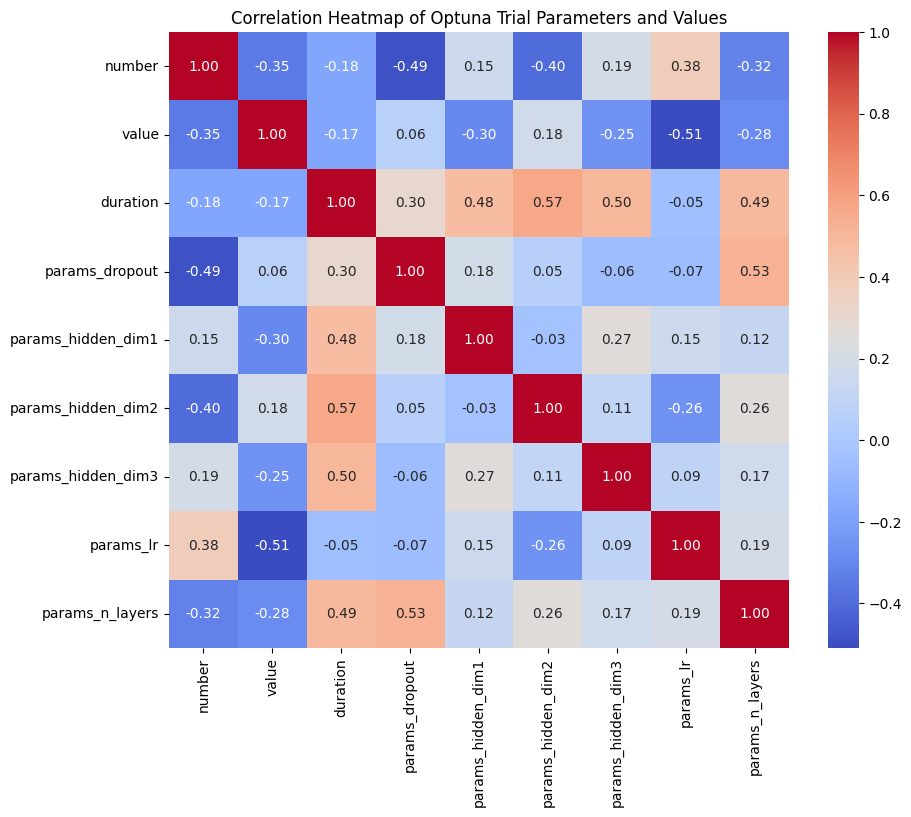

In [49]:
#plotting a heatmap of the optuna results
import seaborn as sns
import matplotlib.pyplot as plt

optuna_df = study.trials_dataframe()
plt.figure(figsize=(10, 8))
sns.heatmap(optuna_df.select_dtypes(include=['number']).corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap of Optuna Trial Parameters and Values")
plt.show()

In [42]:
# === Extract best hyperparameters from Optuna ===
best_params = best_trial.params

# Build hidden layers tuple
n_layers = best_params["n_layers"]
best_hidden_dims = tuple([
    best_params["hidden_dim1"],
    best_params["hidden_dim2"],
    best_params["hidden_dim3"],
][:n_layers])

best_dropout = best_params["dropout"]
best_lr = best_params["lr"]

print("Using hidden_dims =", best_hidden_dims)
print("dropout =", best_dropout)
print("learning rate =", best_lr)


Using hidden_dims = (176, 112, 208)
dropout = 0.0
learning rate = 0.006714041425300983


Best config: medium_lr_high


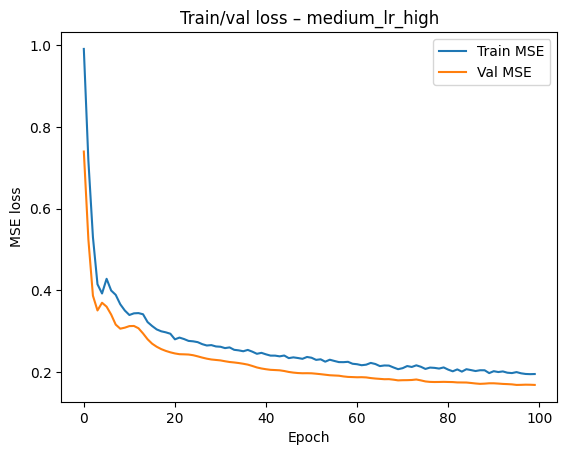

In [43]:
import matplotlib.pyplot as plt

y_pred_test_unscaled = y_scaler.inverse_transform(y_pred_test.reshape(-1, 1))
y_test_unscaled      = y_scaler.inverse_transform(y_test.reshape(-1, 1))

# Plotting train/val loss curves for best config
best_name = results_df.sort_values("val_mse").iloc[0]["name"]
print("Best config:", best_name)

train_losses = histories[best_name]["train_losses"]
val_losses   = histories[best_name]["val_losses"]

plt.figure()
plt.plot(train_losses, label="Train MSE")
plt.plot(val_losses,   label="Val MSE")
plt.xlabel("Epoch")
plt.ylabel("MSE loss")
plt.legend()
plt.title(f"Train/val loss – {best_name}")
plt.show()


Best Optuna params: {'hidden_dim1': 176, 'hidden_dim2': 112, 'hidden_dim3': 208, 'n_layers': 3, 'dropout': 0.0, 'lr': 0.006714041425300983}
Using hidden_dims = (176, 112, 208) dropout = 0.0 lr = 0.006714041425300983


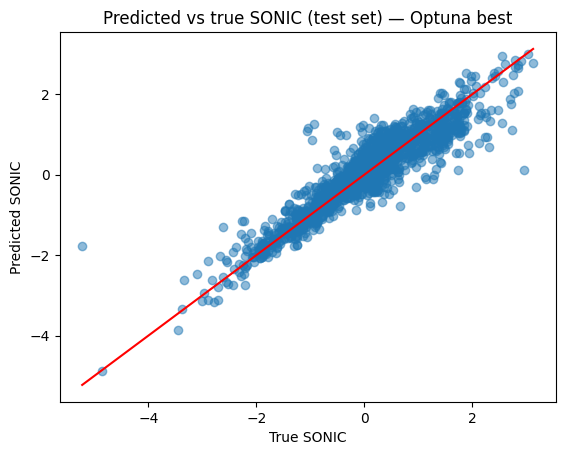

In [44]:
# Use Optuna best trial to rebuild & retrain the model, then plot preds vs true
params = best_trial.params
n_layers = params.get("n_layers", 2)
hidden_dims = tuple([params["hidden_dim1"], params["hidden_dim2"], params["hidden_dim3"]][:n_layers])
dropout = params.get("dropout", 0.0)
lr = params.get("lr", 1e-3)

print("Best Optuna params:", params)
print("Using hidden_dims =", hidden_dims, "dropout =", dropout, "lr =", lr)

# Reproducibility
torch.manual_seed(NP_RANDOM_SEED)
np.random.seed(NP_RANDOM_SEED)

# Build and train model using Optuna params
model = make_model(
    hidden_dims=hidden_dims,
    dropout=dropout,
    activation=nn.ReLU,
)
model, _, _, _ = train_model(
    model,
    X_train, y_train,
    X_val,   y_val,
    lr=lr,
    epochs=100,
    verbose=False,
)

# Predictions on test set
model.eval()
with torch.no_grad():
    y_pred_test = model(X_test).cpu().numpy()
y_true_test = y_test.cpu().numpy()

# Scatter plot
plt.figure()
plt.scatter(y_true_test, y_pred_test, alpha=0.5)
plt.xlabel("True SONIC")
plt.ylabel("Predicted SONIC")
plt.title("Predicted vs true SONIC (test set) — Optuna best")
plt.plot([y_true_test.min(), y_true_test.max()],
         [y_true_test.min(), y_true_test.max()], color="red")
plt.show()


Data shape after cleaning: X=(12428, 11), y=(12428,)
Seed 0: R² = 0.8440
Seed 0: R² = 0.8440
Data shape after cleaning: X=(12428, 11), y=(12428,)
Data shape after cleaning: X=(12428, 11), y=(12428,)
Seed 1: R² = 0.8539
Seed 1: R² = 0.8539
Data shape after cleaning: X=(12428, 11), y=(12428,)
Data shape after cleaning: X=(12428, 11), y=(12428,)
Seed 2: R² = 0.8491
Seed 2: R² = 0.8491
Data shape after cleaning: X=(12428, 11), y=(12428,)
Data shape after cleaning: X=(12428, 11), y=(12428,)
Seed 3: R² = 0.8548
Seed 3: R² = 0.8548
Data shape after cleaning: X=(12428, 11), y=(12428,)
Data shape after cleaning: X=(12428, 11), y=(12428,)
Seed 4: R² = 0.8398
R² scores: [0.8440262079238892, 0.8539151549339294, 0.8490656018257141, 0.8547860383987427, 0.8398316502571106]
Mean R²: 0.8483249306678772
Std  R²: 0.005729920480848791
Seed 4: R² = 0.8398
R² scores: [0.8440262079238892, 0.8539151549339294, 0.8490656018257141, 0.8547860383987427, 0.8398316502571106]
Mean R²: 0.8483249306678772
Std  R²: 0.00

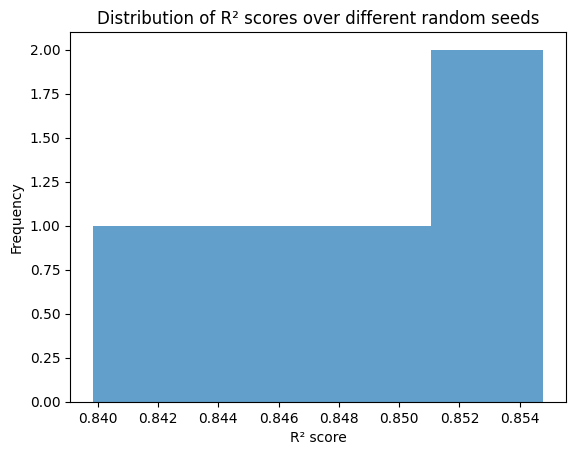

In [47]:
"""
Making a accuracy test for regression by calculating R² score.
"""

from sklearn.metrics import r2_score

seeds = [0, 1, 2, 3, 4]
scores = []

for seed in seeds:
    # 1. new random split
    (X_train, y_train), (X_val, y_val), (X_test, y_test), x_scaler, y_scaler = load_log_data(None)

    # 2. train model with same hyperparameters
    torch.manual_seed(seed)
    np.random.seed(seed)

    model = make_model(  # use best params fra Optuna
        hidden_dims = hidden_dims,
        dropout = best_dropout,
        activation = nn.ReLU,
    )

    model, best_val_mse, train_losses, val_losses = train_model(
        model,
        X_train, y_train,
        X_val,   y_val,
        lr=best_lr,
        epochs=100,
        verbose=False,
    )

    # 3. evaluate on test
    model.eval()
    with torch.no_grad():
        y_pred_test = model(X_test)

    r2 = r2_score(
        y_test.numpy().ravel(),
        y_pred_test.numpy().ravel()
    )
    print(f"Seed {seed}: R² = {r2:.4f}")
    scores.append(r2)

print("R² scores:", scores)
print("Mean R²:", np.mean(scores))
print("Std  R²:", np.std(scores))

plt.figure()
plt.hist(scores, bins='auto', alpha=0.7)
plt.xlabel("R² score")
plt.ylabel("Frequency")
plt.title("Distribution of R² scores over different random seeds")
plt.show()



Ridge baseline:
Test MSE: 0.3378293812274933
Test R²: 0.6565427780151367


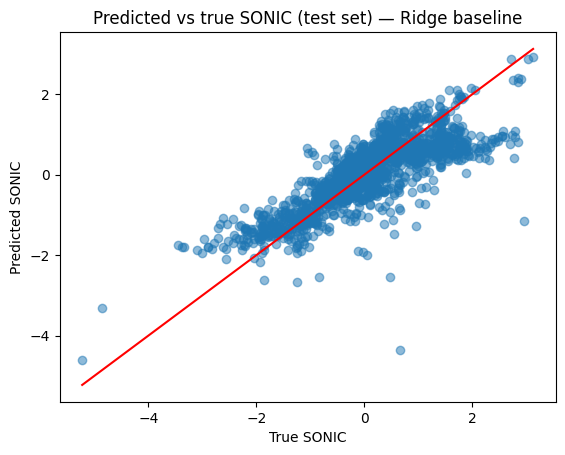

In [46]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score

# Convert tensors to numpy
X_tr = X_train.numpy()
y_tr = y_train.numpy().ravel()
X_te = X_test.numpy()
y_te = y_test.numpy().ravel()

ridge = Ridge(alpha=1.0)
ridge.fit(X_tr, y_tr)

ridge_pred = ridge.predict(X_te)

ridge_mse = mean_squared_error(y_te, ridge_pred)
ridge_r2  = r2_score(y_te, ridge_pred)

print("Ridge baseline:")
print("Test MSE:", ridge_mse)
print("Test R²:", ridge_r2)

plt.figure()
plt.scatter(y_te, ridge_pred, alpha=0.5)
plt.xlabel("True SONIC")
plt.ylabel("Predicted SONIC")
plt.title("Predicted vs true SONIC (test set) — Ridge baseline")
plt.plot([y_te.min(), y_te.max()],
            [y_te.min(), y_te.max()], color="red")
plt.show()
